In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier,AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})

In [2]:
normalize = False
BEST_FEATURES = True
TARGET_ENCODING = False
TRAIN_WITH_CATS = False
LIGHT_GBM = True
CAT_BOOST = False

In [3]:
y_train = pd.read_csv('../input/kyivstar-bigdata-2020/train.csv')
y_test = pd.read_csv('../input/kyivstar-bigdata-2020/test.csv')
tabular_data = pd.read_csv('../input/kyivstar-bigdata-2020/tabular_data.csv')
id_ = tabular_data.id
hashed_feature = pd.read_csv('../input/kyivstar-bigdata-2020/hashed_feature.csv')

In [4]:
y_train.shape, y_test.shape

((4084, 2), (1022, 2))

In [5]:
tabular_data = tabular_data.fillna(tabular_data.mean())

In [6]:
tabular_data = tabular_data.drop(['feature_41'], axis = 1)

In [7]:
def split_objf(df, unique_num):
    for i in df.columns:
        if df[i].nunique() <= unique_num:
            pos_enc = [j for j in df.columns if df[j].nunique() <= unique_num]
            return pos_enc
unique_num = 300
cat_features = split_objf(tabular_data, unique_num=unique_num)
tabular_cats = tabular_data[cat_features]
tabular_data = tabular_data.drop(cat_features, axis = 1)

In [8]:
tabular_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61272 entries, 0 to 61271
Data columns (total 43 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          61272 non-null  int64  
 1   feature_1   61272 non-null  float64
 2   feature_2   61272 non-null  float64
 3   feature_3   61272 non-null  float64
 4   feature_4   61272 non-null  float64
 5   feature_5   61272 non-null  float64
 6   feature_6   61272 non-null  float64
 7   feature_7   61272 non-null  float64
 8   feature_8   61272 non-null  float64
 9   feature_9   61272 non-null  float64
 10  feature_10  61272 non-null  float64
 11  feature_11  61272 non-null  float64
 12  feature_12  61272 non-null  float64
 13  feature_13  61272 non-null  float64
 14  feature_16  61272 non-null  float64
 15  feature_17  61272 non-null  float64
 16  feature_18  61272 non-null  float64
 17  feature_19  61272 non-null  float64
 18  feature_20  61272 non-null  float64
 19  feature_21  61272 non-nul

In [9]:
tabular_data = tabular_data.groupby('id').agg(['mean', 'max', 'min', 'sum']) #,
tabular_data.columns = ["_".join(i) for i in tabular_data.columns.ravel()]
tabular_data = tabular_data.reset_index(drop = True)
tabular_data

,feature_1_mean,feature_1_max,feature_1_min,feature_1_sum,feature_2_mean,feature_2_max,feature_2_min,feature_2_sum,feature_3_mean,feature_3_max,...,feature_47_min,feature_47_sum,feature_48_mean,feature_48_max,feature_48_min,feature_48_sum,feature_49_mean,feature_49_max,feature_49_min,feature_49_sum
0,60.916667,110.000000,55.0,731.000000,0.238880,0.552340,0.083655,2.866555,293.635812,1099.289203,...,85.0,1714.000000,315.011667,702.920000,91.120000,3780.140000,0.250000,2.000000,0.0,3.000000
1,135.541667,230.000000,125.0,1626.500000,0.060443,0.218627,0.018295,0.725314,6940.579852,13647.313124,...,77.0,1631.000000,288.885904,288.885904,288.885904,3466.630853,204.334131,2433.009568,0.0,2452.009568
2,0.597500,6.000000,0.0,7.170000,0.713310,5.203073,0.305150,8.559721,0.141369,1.696433,...,0.0,121.000000,2.470000,18.530000,0.000000,29.640000,0.000000,0.000000,0.0,0.000000
3,80.981807,87.142409,33.5,971.781683,0.685844,5.170391,0.008239,8.230128,2631.539627,3747.802363,...,45.0,1446.667448,230.493595,288.885904,4.470000,2765.923140,48.390684,62.298690,2.0,580.688209
4,126.000000,302.000000,30.5,1512.000000,0.133693,0.177734,0.071258,1.604314,2568.283478,5491.642975,...,106.0,2284.000000,288.885904,288.885904,288.885904,3466.630853,208.911004,2297.932045,8.0,2506.932045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5101,94.166667,151.500000,75.0,1130.000000,0.292280,0.503273,0.129016,3.507360,180.142899,1174.050537,...,131.0,2007.000000,858.400833,1754.230000,373.970000,10300.810000,6.500000,15.000000,0.0,78.000000
5102,80.675000,102.500000,32.6,968.100000,0.755737,5.184616,0.249870,9.068844,0.000000,0.000000,...,53.0,1229.000000,187.505833,378.230000,28.900000,2250.070000,1.666667,8.000000,0.0,20.000000
5103,22.568333,70.000000,0.0,270.820000,0.801533,4.998246,0.286167,9.618391,0.000000,0.000000,...,6.0,207.000000,288.885904,288.885904,288.885904,3466.630853,7.666667,19.000000,0.0,92.000000
5104,86.230833,190.000000,75.0,1034.770000,0.068594,0.101403,0.041683,0.823126,988.894377,2153.343195,...,36.0,731.000000,49.870833,87.570000,21.080000,598.450000,4.583333,17.000000,0.0,55.000000


In [10]:
freq_feature = hashed_feature.groupby(['id']).count().reset_index()
freq_feature = freq_feature.drop(['id'], axis=1)

In [11]:
tabular_data = pd.concat([tabular_data, freq_feature], axis=1)

In [12]:
X = tabular_data.copy()

In [13]:
X_train = X.iloc[0:4084,:]
X_test = X.iloc[4084:, :]
X_train.shape, X_test.shape

((4084, 169), (1022, 169))

In [14]:
if BEST_FEATURES:
    best_features = [5, 7, 11, 12, 14, 16, 18, 22, 26, 35, 38, 39, 42, 153, 155, 168] 
    X_train = X_train.iloc[:, best_features]
    X_test = X_test.iloc[:, best_features]

In [15]:
BEST_FEATURES

True

In [16]:
corr_df = X_train.copy()
corr_df['target'] = y_train.target
#corr_df.corr()

In [17]:
X_train.isnull().sum().max()

0

In [18]:
tabular_cats['id'] = id_
cat_train = tabular_cats[tabular_cats.id <= 4083]
cat_test = tabular_cats[tabular_cats.id >= 4083]

In [19]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
cat_train.feature_25 = pd.Series(le.fit_transform(cat_train.feature_25))
cat_test.feature_25 = pd.Series(le.fit_transform(cat_test.feature_25))

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [20]:
cat_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49008 entries, 0 to 49007
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   period      49008 non-null  int64  
 1   feature_0   49008 non-null  float64
 2   feature_14  49008 non-null  float64
 3   feature_15  49008 non-null  float64
 4   feature_24  49008 non-null  float64
 5   feature_25  49008 non-null  int64  
 6   feature_43  49008 non-null  float64
 7   feature_45  49008 non-null  float64
 8   id          49008 non-null  int64  
dtypes: float64(6), int64(3)
memory usage: 3.7 MB


In [21]:
cat_train = cat_train.groupby('id').mean().reset_index()
cat_test = cat_test.groupby('id').mean().reset_index()
cat_train = cat_train.drop(['id'], axis=1)
cat_test = cat_test.drop(['id'], axis=1)

In [22]:
cat_train = cat_train.drop(['period'], axis=1)
cat_train

,feature_0,feature_14,feature_15,feature_24,feature_25,feature_43,feature_45
0,110.000000,0.000000,6.750000,0.000000,2.50,0.000000,0.750000
1,110.000000,0.083333,19.583333,0.083333,7.00,0.083333,6.750000
2,110.166667,0.000000,0.416667,0.000000,2.75,0.000000,0.000000
3,110.052869,2.866729,10.699525,2.824369,1.75,0.986130,9.713053
4,110.000000,0.083333,21.083333,0.166667,7.00,0.166667,36.333333
...,...,...,...,...,...,...,...
4079,110.000000,0.083333,0.000000,0.166667,2.00,0.166667,3.833333
4080,110.000000,0.583333,0.000000,0.333333,7.00,0.416667,6.666667
4081,110.000000,0.000000,0.000000,0.000000,3.00,0.000000,24.583333
4082,110.000000,0.000000,0.666667,0.000000,3.00,0.000000,2.083333


In [23]:
np.corrcoef(cat_train.feature_14, y_train.target)

array([[1.        , 0.05185223],
       [0.05185223, 1.        ]])

In [24]:
cat_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4084 entries, 0 to 4083
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_0   4084 non-null   float64
 1   feature_14  4084 non-null   float64
 2   feature_15  4084 non-null   float64
 3   feature_24  4084 non-null   float64
 4   feature_25  4084 non-null   float64
 5   feature_43  4084 non-null   float64
 6   feature_45  4084 non-null   float64
dtypes: float64(7)
memory usage: 223.5 KB


In [25]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
   
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

if TARGET_ENCODING:
    
    feature_25_train, feature_25_test = target_encode(cat_train.feature_25,cat_test.feature_25, 
                        target=y_train.target, 
                        min_samples_leaf=100,
                        smoothing=5,
                        noise_level=0.01)
    
    feature_0_train, feature_0_test = target_encode(cat_train.feature_0,cat_test.feature_0, 
                        target=y_train.target, 
                        min_samples_leaf=100,
                        smoothing=5,
                        noise_level=0.01)
    
    feature_15_train, feature_15_test = target_encode(cat_train.feature_15,cat_test.feature_15, 
                        target=y_train.target, 
                        min_samples_leaf=100,
                        smoothing=5,
                        noise_level=0.01)
    
    feature_24_train, feature_24_test = target_encode(cat_train.feature_24,cat_test.feature_24, 
                        target=y_train.target, 
                        min_samples_leaf=100,
                        smoothing=5,
                        noise_level=0.01)
    
    feature_43_train, feature_43_test = target_encode(cat_train.feature_43,cat_test.feature_43, 
                        target=y_train.target, 
                        min_samples_leaf=100,
                        smoothing=5,
                        noise_level=0.01)
    
    feature_45_train, feature_45_test = target_encode(cat_train.feature_45,cat_test.feature_45, 
                        target=y_train.target, 
                        min_samples_leaf=100,
                        smoothing=5,
                        noise_level=0.01)
    
    cat_train.feature_25 = feature_25_train
    cat_test.feature_25 = feature_25_test
    
    cat_train.feature_0 = feature_0_train
    cat_test.feature_0 = feature_0_test
    
    cat_train.feature_15 = feature_15_train
    cat_test.feature_15 = feature_15_test
    
    cat_train.feature_24 = feature_24_train
    cat_test.feature_24 = feature_24_test
    
    cat_train.feature_43 = feature_43_train
    cat_test.feature_43 = feature_43_test
    
    cat_train.feature_45 = feature_45_train
    cat_test.feature_45 = feature_45_test

In [26]:
#np.corrcoef(trn, y_train.target)

In [27]:
if TRAIN_WITH_CATS:
    X_train = pd.concat([X_train, cat_train], axis=1)

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4084 entries, 0 to 4083
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   feature_2_max   4084 non-null   float64
 1   feature_2_sum   4084 non-null   float64
 2   feature_3_sum   4084 non-null   float64
 3   feature_4_mean  4084 non-null   float64
 4   feature_4_min   4084 non-null   float64
 5   feature_5_mean  4084 non-null   float64
 6   feature_5_min   4084 non-null   float64
 7   feature_6_min   4084 non-null   float64
 8   feature_7_min   4084 non-null   float64
 9   feature_9_sum   4084 non-null   float64
 10  feature_10_min  4084 non-null   float64
 11  feature_10_sum  4084 non-null   float64
 12  feature_11_min  4084 non-null   float64
 13  feature_46_max  4084 non-null   float64
 14  feature_46_sum  4084 non-null   float64
 15  feature_50      4084 non-null   int64  
dtypes: float64(15), int64(1)
memory usage: 510.6 KB


In [29]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    if CAT_BOOST:
        y_predict = cb_model.predict_proba(X_train.iloc[index])[:,1]
    elif LIGHT_GBM:
        y_predict = clf.predict_proba(X_train.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y_train.target.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

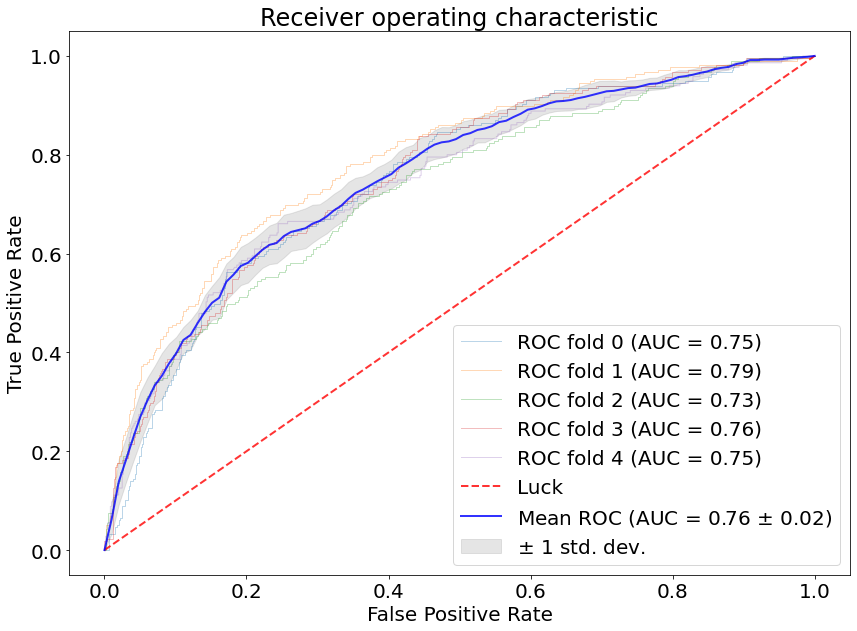

In [30]:
import lightgbm as lgb

if LIGHT_GBM:
    params = {
        'boosting_type': 'gbdt',
        'max_depth' : 5,
        'objective': 'binary',
        'num_leaves': 64,
        'learning_rate': 0.05,
        'max_bin': 512,
        'subsample_for_bin': 200,
        'subsample': 1,
        'subsample_freq': 1,
        'colsample_bytree': 0.8, 
        'reg_alpha': 5,
        'reg_lambda': 10,
        'min_split_gain': 0.5,
        'min_child_weight': 2,
        'min_child_samples': 5,
        'scale_pos_weight': 1,
        'num_class' : 1,
        'metric' : 'roc',
    }
    cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])
    fprs, tprs, scores = [], [], []

    clf = lgb.LGBMClassifier(**params)

    for (train, test), i in zip(cv.split(X_train, y_train.target), range(5)):
        clf.fit(X_train.iloc[train], y_train.target.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train)
        fpr, tpr, auc_score = compute_roc_auc(test)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)

    plot_roc_curve(fprs, tprs);
    res = pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])
    res

In [31]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_features_indices

array([15])

In [32]:
categorical_features_pos = np.array([13, 14, 15, 16, 17, 18, 19])

In [33]:
from catboost import CatBoostClassifier

if CAT_BOOST:
    
    params = {
        'iterations': 200,
        'learning_rate': 0.5,
        'depth': 3,
        'l2_leaf_reg': 40,
        'bootstrap_type': 'Bernoulli',
        'subsample': 0.7,
        'scale_pos_weight': 5,
        'eval_metric': 'AUC',
        'od_type': 'Iter',
        'allow_writing_files': False,
        'loss_function':'Logloss',
    }
    
    cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])
    fprs, tprs, scores = [], [], []
    
    cb_model = CatBoostClassifier(**params)
    
    for (train, test), i in zip(cv.split(X_train, y_train.target), range(5)):
        cb_model.fit(X_train.iloc[train].values, y_train.target.iloc[train].values,
             eval_set=(X_train.iloc[test],y_train.target.iloc[test]),
             #cat_features=categorical_features_pos,
             use_best_model=True,
             verbose=True)
        
        _, _, auc_score_train = compute_roc_auc(train)
        fpr, tpr, auc_score = compute_roc_auc(test)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        
    plot_roc_curve(fprs, tprs);
    res = pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])
    res

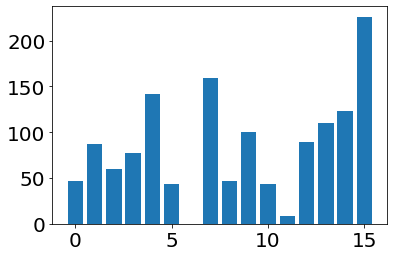

In [34]:
if CAT_BOOST:
    importance = cb_model.feature_importances_
elif LIGHT_GBM:
    importance = clf.feature_importances_
fe_dict = []
for i,v in enumerate(importance):
    #print('Feature: %0d, Score: %.5f' % (i,v))
    fe_dict.append({"feature_num": i, "score": v})
    
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [35]:
res.mean()

AUC Train    0.821908
AUC Test     0.755913
dtype: float64

In [36]:
fe_df = pd.DataFrame(fe_dict)
best_features = list(fe_df.feature_num[fe_df.score > 5])
best_features

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [37]:
X_train.iloc[:, best_features]

,feature_2_max,feature_2_sum,feature_3_sum,feature_4_mean,feature_4_min,feature_5_mean,feature_6_min,feature_7_min,feature_9_sum,feature_10_min,feature_10_sum,feature_11_min,feature_46_max,feature_46_sum,feature_50
0,0.552340,2.866555,3523.629746,430.134167,159.25,0.000000,0.316798,391.127914,3.740000,156.13,5152.770000,55.00,0.776175,6.009026,10
1,0.218627,0.725314,83286.958225,1119.352500,631.70,0.000000,0.103532,392.570000,4792.498484,631.15,13387.470000,-145.00,0.665440,4.068892,43
2,5.203073,8.559721,1.696433,4.168333,0.00,0.000000,0.119820,391.127914,0.000000,0.00,44.540000,0.00,0.420170,2.566367,14
3,5.170391,8.230128,31578.475518,329.931203,6.67,1099.895548,0.576053,62.500000,1042.956985,6.20,3713.040859,33.50,0.758731,5.852904,6
4,0.177734,1.604314,30819.401741,460.332500,251.73,0.000000,0.472205,240.520000,533.350000,232.05,4950.060000,30.50,0.965164,9.431095,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4079,0.721437,5.118865,0.000000,114.083333,59.13,0.000000,0.184032,108.100000,131.920000,44.45,1230.680000,-48.50,0.684405,5.172506,17
4080,5.282176,8.967632,0.000000,37.928333,4.20,0.000000,0.171789,4.600000,1376.849313,0.00,370.640000,-55.00,0.692862,4.701403,4
4081,0.764390,6.616630,0.000000,35.915000,0.00,0.000000,0.059876,36.630000,32.170000,0.00,373.380000,-40.49,0.864929,6.068331,8
4082,5.449248,12.822861,469.627334,4107.516667,75.95,0.000000,0.017839,130.120000,123.470000,74.72,49025.220000,0.00,0.519355,2.914990,7


In [38]:
if CAT_BOOST:
    test_preds = cb_model.predict_proba(X_test)[:,1]
elif LIGHT_GBM:
    test_preds = clf.predict_proba(X_test)[:,1]

In [39]:
y_test.score = test_preds
y_test

,id,score
0,4084,0.077968
1,4085,0.118458
2,4086,0.086783
3,4087,0.181897
4,4088,0.322290
...,...,...
1017,5101,0.210672
1018,5102,0.500738
1019,5103,0.174096
1020,5104,0.204360


In [40]:
if CAT_BOOST:
    y_test.to_csv('catboost_sub.csv', index=False)
elif LIGHT_GBM:
    y_test.to_csv('lightgbm_sub.csv',index=False)